In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from uncertainty_forest.uncertainty_forest import UncertaintyForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from scipy.stats import entropy, norm
from scipy.integrate import quad

## Simulate Data and Conditional Entropy Prediction

In [2]:
def generate_data(n, d, frac_eval, mu = 1, sigma = 1):
    n_1 = np.random.binomial(n, .5) # number of class 1
    mean = np.zeros(d)
    mean[0] = mu
    X_1 = np.random.multivariate_normal(mean, sigma * np.eye(d), n_1)
    
    X = np.concatenate((X_1, np.random.multivariate_normal(-mean, sigma * np.eye(d), n - n_1)))
    y = np.concatenate((np.repeat(1, n_1), np.repeat(-1, n - n_1)))
    
    # Evaluation data.
    n_eval = int(np.floor(frac_eval*n))
    eval_indices = np.random.choice(np.arange(n), size = n_eval, replace = False)
    X_eval = X[eval_indices, :]
    X = np.delete(X, eval_indices, axis = 0)
    y = np.delete(y, eval_indices, axis = 0)
    return X, y, X_eval

In [4]:
def conditional_entropy_distribution(n, d, frac_eval, algos, num_trials, mu, parallel = False):
    # For each trial, generate data and compute conditional entropy for each algorithm.
    def worker(t):
        X, y, X_eval = generate_data(n, d, frac_eval, mu = mu)
        ret = np.zeros(len(algos))
        for i in range(len(algos)):
            obj = algos[i]['instance']
            obj.fit(X, y)
            p = obj.predict_proba(X_eval)
            ret[i] = np.mean(entropy(p.T, base = 2))
        return ret
    
    if parallel:
        predicted_cond_entropy = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
    else:
        predicted_cond_entropy = np.zeros((num_trials, len(algos)))
        for t in tqdm(range(num_trials)):
            predicted_cond_entropy[t, :] = worker(t)
            
    return predicted_cond_entropy

## Compute True Conditional Entropy

In [5]:
def true_cond_entropy(mu, sigma = 1):
    def func(x):
        p = 0.5 * norm.pdf(x, mu, sigma) + 0.5 * norm.pdf(x, -mu, sigma)
        return -p * np.log2(p)
    
    H_X = quad(func, -20, 20)
    H_XY = 0.5*(1.0/np.log(2.0) + np.log2(2 * np.pi))
    H_Y = 1
    # I_XY = H_X - H_XY = H_Y - H_YX
    return H_Y - H_X[0] + H_XY

## Conditional Entropy versus Sample Size

In [6]:
def conditional_entropy_by_n(sample_sizes, d, frac_eval, algos, num_trials, mu, parallel = False):
    # Repeat for all 'n', and save output in the 'algos' array.
    cond_entropy_range = np.zeros((len(sample_sizes), num_trials, len(algos)))
    for i in range(len(sample_sizes)):
        cond_entropy_range[i, :, :] = conditional_entropy_distribution(sample_sizes[i], 
                                                                       d, 
                                                                       frac_eval, 
                                                                       algos, 
                                                                       num_trials, 
                                                                       mu = mu,
                                                                       parallel = parallel)
        
    for j in range(len(algos)):
        algos[j]['cond_entropy_by_n_d_%d' % d] = cond_entropy_range[:, :, j]
        
    with open('algos_fig2.pkl', 'wb') as f:
        pickle.dump(algos, f)
    with open('sample_sizes_d_%d.pkl' % d, 'wb') as f:
        pickle.dump(sample_sizes, f)

In [7]:
def plot_cond_entropy_by_n(ax, num_plotted_trials, d, mu = 1):
    with open('sample_sizes_d_%d.pkl' % d, 'rb') as f:
        sample_sizes = pickle.load(f)
    with open('algos_fig2.pkl', 'rb') as f:
        algos = pickle.load(f)
    
    for algo in algos:
        # Plot the mean over trials as a solid line.
        ax.plot(sample_sizes,
                np.mean(algo['cond_entropy_by_n_d_%d' % d], axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 4, 
                color = algo['color'])
        # Use transparent lines to show other trials.
        for t in range(num_plotted_trials):
            ax.plot(sample_sizes, 
                    algo['cond_entropy_by_n_d_%d' % d][:, t].flatten(),  
                    linewidth = 2, 
                    color = algo['color'],
                    alpha = 0.15)
    
    truth = true_cond_entropy(mu)
    ax.axhline(y = truth, linestyle = '-', color = "black", label = "Truth")
            
    ax.set_xlabel("Sample Size")
    ax.set_ylabel("Estimated Conditional Entropy")
    ax.set_title("Effect Size = %.1f, d = %d" % (mu, d))
    ax.set_ylim(ymin = -0.05)

## Conditional Entropy Estimates versus Effect Size

In [8]:
def conditional_entropy_by_mu(mus, n, d, frac_eval, algos, num_trials, parallel = False):
    # Repeat for all 'mu', and save output in the 'algos' array.
    cond_entropy_range = np.zeros((len(mus), num_trials, len(algos)))
    for i in range(len(mus)):
        cond_entropy_range[i, :, :] = conditional_entropy_distribution(n, 
                                                                       d, 
                                                                       frac_eval, 
                                                                       algos, 
                                                                       num_trials, 
                                                                       mu = mus[i],
                                                                       parallel = parallel)      
    for j in range(len(algos)):
        algos[j]['cond_entropy_by_mu_d_%d' % d] = cond_entropy_range[:, :, j]
        
    with open('algos_fig2.pkl', 'wb') as f:
        pickle.dump(algos, f)
    with open('mus_fig2.pkl', 'wb') as f:
        pickle.dump(mus, f)

In [9]:
def plot_cond_entropy_by_mu(ax, d, n):
    with open('mus_fig2.pkl', 'rb') as f:
        mus = pickle.load(f)
    with open('algos_fig2.pkl', 'rb') as f:
        algos = pickle.load(f)
        
    for algo in algos:
        # Plot the mean over trials as a solid line.
        ax.plot(mus, 
                np.mean(algo['cond_entropy_by_mu_d_%d' % d], axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 4, 
                color = algo['color'])
    
    truth = [true_cond_entropy(mu) for mu in mus]
    ax.plot(mus, truth, label = 'Truth', linewidth = 4, color = 'black')

    ax.set_ylim(ymin = -.05)
    ax.set_title("n = %d, d = %d" % (n, d))
    ax.set_xlabel("Effect Size")
    ax.set_ylabel("Estimated Conditional Entropy")

In [10]:
def plot_fig2(num_plotted_trials, d1, d2, n1, n2):
    sns.set(font_scale = 3)
    sns.set_style("ticks")
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams['figure.figsize'] = [30, 20]
    fig, axes = plt.subplots(2, 2)
    
    plot_cond_entropy_by_n(axes[0, 0], num_plotted_trials, d1)
    plot_cond_entropy_by_n(axes[0, 1], num_plotted_trials, d2)
                                                  
    plot_cond_entropy_by_mu(axes[1, 0], d1, n1)
    plot_cond_entropy_by_mu(axes[1, 1], d2, n2)
    
    plt.tight_layout()
    plt.savefig("fig2.pdf")
    plt.show()

## Run Experiments and Plot

In [11]:
# Data.
mus = [i * 0.5 for i in range(1, 11)]
frac_eval = 0.3
n_estimators = 500
d1 = 1
d2 = 40
n1 = 3000
n2 = 8000
num_trials_n = 100
num_trials_mu = 15
sample_sizes_d1 = range(100, 2501, 300)
sample_sizes_d2 = range(100, 5001, 700)

# Algorithms.
algos = [
    {
        'instance': RandomForestClassifier(n_estimators = n_estimators),
        'label': 'CART',
        'title': 'CART Forest',
        'color': "#1b9e77",
    },
    {
        'instance': CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = n_estimators), 
                                           method='isotonic', 
                                           cv = 5),
        'label': 'IRF',
        'title': 'Isotonic Reg. Forest',
        'color': "#fdae61",
    },
    {
        'instance': UncertaintyForest(n_estimators = n_estimators),
        'label': 'UF',
        'title': 'Uncertainty Forest',
        'color': "#F41711",
    },
]

# Other.
num_plotted_trials = 5
parallel = True

### Estimated H(Y | X) versus n, d = 1

In [12]:
# Estimate conditional entropy vs n.
conditional_entropy_by_n(sample_sizes_d1, d1, frac_eval, algos, num_trials_n, 1, parallel = parallel)
print(algos[0]['cond_entropy_by_n_d_%d' % d1])

[[0.33980053 0.25807799 0.19470726]
 [0.18615244 0.30307782 0.15760998]]


In [13]:
# plot_cond_entropy_by_n(num_plotted_trials, 1)

### Estimated H(Y | X) versus mu, d = 1

In [14]:
# Estimate conditional entropy vs mu.
conditional_entropy_by_mu(mus, n1, d1, frac_eval, algos, num_trials_mu, parallel = parallel)
print(algos[0]['cond_entropy_by_mu_d_%d' % d1])

[[0.41731898 0.32917215 0.40848335]
 [0.40562502 0.22479127 0.15365049]
 [0.3130507  0.16550366 0.19255659]
 [0.01563319 0.02406427 0.01563319]
 [0.01563319 0.02406427 0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]


In [16]:
# Estimate conditional entropy vs n.
conditional_entropy_by_n(sample_sizes_d2, d2, frac_eval, algos, num_trials_n, 1, parallel = parallel)
print(algos[0]['cond_entropy_by_n_d_%d' % d2])

[[0.25917664 0.48560144 0.5237957 ]
 [0.46444591 0.43602193 0.36368769]]


In [18]:
# Estimate conditional entropy vs mu.
conditional_entropy_by_mu(mus, n2, d2, frac_eval, algos, num_trials_mu, parallel = parallel)
print(algos[0]['cond_entropy_by_mu_d_%d' % d2])

[[0.71957994 0.6376183  0.70309972]
 [0.50188492 0.46368411 0.41893593]
 [0.34942951 0.29130344 0.26144062]
 [0.19010133 0.10714854 0.09293655]
 [0.05972578 0.09293655 0.11481316]
 [0.21086069 0.10543034 0.08060361]
 [0.13668977 0.1136959  0.12247778]
 [0.07872456 0.25772489 0.22962631]
 [0.1497845  0.29353795 0.26566505]
 [0.1497845  0.19836689 0.13385432]]


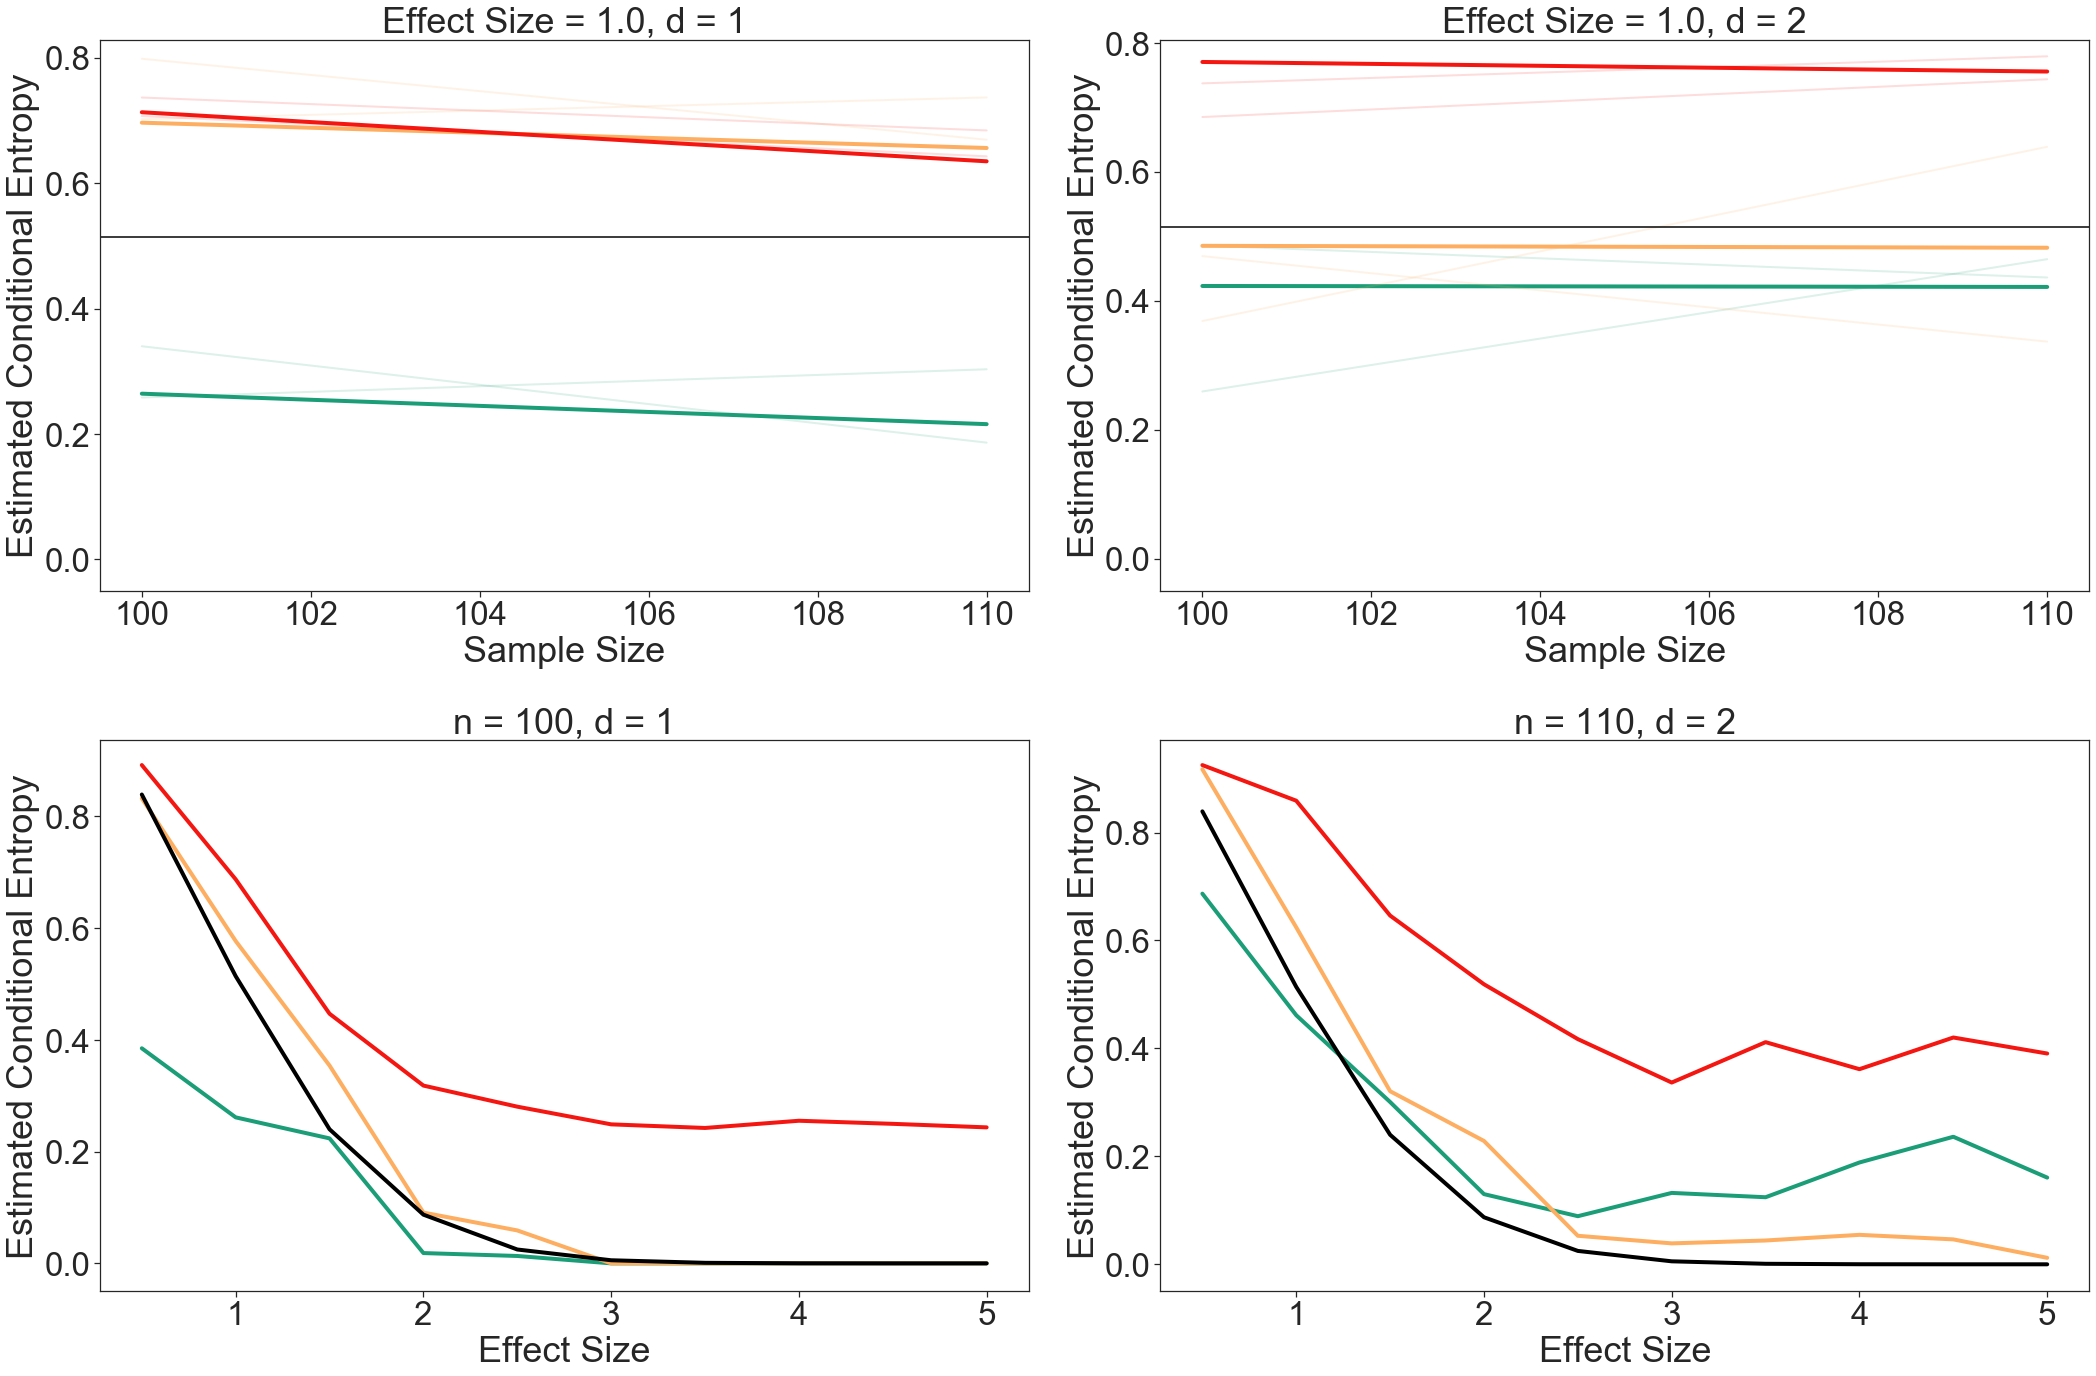

In [20]:
plot_fig2(num_plotted_trials, d1, d2, n1, n2)